In [ ]:
from sklearn.model_selection import train_test_split # Import the function from the correct module
import pandas as pd
df1= pd.read_csv('inputdict.csv')
reviews=pd.read_csv('output.csv')
# Convert to DataFrame
df = pd.DataFrame({'review': reviews['text'], 'sentiment': reviews['label']})
df.dropna(inplace=True)
X = df.drop('sentiment', axis=1)  # Replace 'target_variable_column' with the actual column name
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
X_train

,review
1675,this hydrates so well especially in the winter...
2798,i received this complimentary from dermalogic...
1503,solid mask that helps subside any breakouts th...
2480,bought and the first one took a year ish to f...
1491,i really love these wipes they take my makeup ...
...,...
4426,this product and brand is amazing ive got very...
466,i think this is a different formulation than t...
3092,this product is perfect for my oily prone skin...
3772,love everything about this from packaging to t...


# ECR Model
Emotion Cognitive Reasoning based model used to identify specific positive and negative emotions in every review and assigning polarity scores based it

In [ ]:
pos_emo=['gratitude','satisfaction','relief','joy']
neg_emo=['unpleasant','disappointment','distress','anger']

## Text Tokenization

In [ ]:
import spacy

# Load the English tokenizer
nlp = spacy.load("en_core_web_sm")

def text_to_word_list_spacy(text):
    doc = nlp(text)
    word_list = [token.text for token in doc]
    return word_list


## Assigning Emotions to Words

In [ ]:

def emotion_words(tk):
  ED=[]
  w=[]
  for i in range(len(tk)):
    row_index = df1.loc[df1['words'] == tk[i]].index
    if not row_index.empty:
      ED.append(df1['Sentiment classification'][row_index])
      w.append(row_index[0])
  ED = [item for sublist in ED for item in sublist]
  emotions=[]
  if ('Desirable' in ED) and ('Praiseworthy' in ED):
    emotions.append('gratitude')
  if ('Unesirable' in ED) and ('Blameworthy' in ED):
    emotions.append('anger')
  if ('Desirable' in ED) and ('Confirmed' in ED):
    emotions.append('satisfaction')
  if ('Undesirable' in ED) and ('Confirmed' in ED):
    emotions.append('unpleasant')
  if ('Desirable' in ED) and ('Disconfirmed' in ED):
    emotions.append('relief')
  if ('Undesirable' in ED) and ('Disconfirmed' in ED):
    emotions.append('disappointment')
  if emotions==[]:
    if ('Desirable' in ED):
      emotions.append('joy')
    elif ('Undesirable' in ED):
      emotions.append('distress')

  return emotions,w


##Finding Sentiment Scores for Reviews

In [ ]:
def senti_intensity(w):
  Sp,Sn=0,0
  for index in w:
    row=df1.loc[index]
    if row['Sentiment classification'] in ['Desirable','Praiseworthy','Confirmed']:
      Sp+=row['strength']
    elif row['Sentiment classification'] in ['Undesirable','Blameworthy','Disconfirmed']:
      Sn+=row['strength']
  try:
    return (Sp-Sn)/(Sp+Sn)
  except ZeroDivisionError:
    return 0


In [ ]:
def fusion_algo(txt):
    tokens=text_to_word_list_spacy(txt)
    emotions,w=emotion_words(tokens)
    ES=senti_intensity(w)
    CSecr=abs(ES)
    return emotions,ES,CSecr

In [ ]:
import time
from tqdm import tqdm

batch_size = 10  # Adjust as needed
results = []
for i in tqdm(range(0, len(reviews), batch_size)):
    batch = reviews['text'][i: i + batch_size]
    batch_results = batch.apply(fusion_algo)
    results.extend(batch_results.tolist())

# Convert results to DataFrame
result_df = pd.DataFrame(results, columns=['emotions', 'ES', 'CSecr'])

# Assign results to original DataFrame
reviews['emotions'] = result_df['emotions']
reviews['ES'] = result_df['ES']
reviews['CSecr'] = result_df['CSecr']

reviews


# RoBERTa Model

In [ ]:
#training a roberta model
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification
import tensorflow as tf

# Load pre-trained RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = TFRobertaForSequenceClassification.from_pretrained('roberta-base')

X_train_tokens = tokenizer(X_train['review'].tolist(), truncation=True, padding=True, return_tensors='tf')
X_test_tokens = tokenizer(X_test['review'].tolist(), truncation=True, padding=True, return_tensors='tf')
# Convert labels to TensorFlow tensors
y_train_tensor = tf.convert_to_tensor(y_train.tolist())
y_test_tensor = tf.convert_to_tensor(y_test.tolist())

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Train the model
model.fit(
    x=X_train_tokens.data,
    y=y_train_tensor,
    epochs=3,
    batch_size=16,
    validation_data=(X_test_tokens.data, y_test_tensor)
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/3
272/272 [==============================] - 440s 1s/step - loss: 0.2200 - accuracy: 0.9203 - val_loss: 0.1680 - val_accuracy: 0.9318
Epoch 2/3
272/272 [==============================] - 368s 1s/step - loss: 0.1117 - accuracy: 0.9591 - val_loss: 0.2095 - val_accuracy: 0.9298
Epoch 3/3
272/272 [==============================] - 359s 1s/step - loss: 0.0795 - accuracy: 0.9747 - val_loss: 0.2212 - val_accuracy: 0.9360


In [ ]:
model.save_pretrained("my_roberta_model")
print("Model saved to the 'my_roberta_model' directory.")


Model saved to the 'my_roberta_model' directory.


In [ ]:
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification
loaded_model = TFRobertaForSequenceClassification.from_pretrained("my_roberta_model")

In [ ]:
!zip -r my_roberta_model.zip my_roberta_model
from google.colab import files
files.download('my_roberta_model.zip')


In [ ]:
reviews=pd.read_csv('output1.csv')
len(reviews)

48367

## Extracting Sentiment Polarity Predictions using RoBERTa

In [ ]:
import numpy as np
X_test_tokens = tokenizer(reviews['text'].tolist(), truncation=True, padding=True, return_tensors='tf')
y_pred_proba = model.predict(X_test_tokens.data)['logits']
y_pred_roberta = np.argmax(y_pred_proba, axis=1)

1512/1512 [==============================] - 1468s 971ms/step


## Assigning Polarity Scores

In [ ]:
y_pred_proba_softmax = np.array(tf.nn.softmax(y_pred_proba, axis=1))
CSbert =np.max(y_pred_proba_softmax,axis=1) # Use tf.gather to index the tensor with the NumPy array converted to a TensorFlow tensor.

In [ ]:
reviews['pca'] = y_pred_proba.tolist()
reviews['predBert'] = y_pred_roberta
reviews['CSbert']=CSbert

In [ ]:
# import torch
# from transformers import AutoTokenizer, AutoModelForSequenceClassification
# from sklearn.decomposition import PCA
# # Load the tokenizer and model
# model_name = 'cardiffnlp/twitter-roberta-base-sentiment-latest'
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForSequenceClassification.from_pretrained(model_name)

# def BERT(review):
#     # Tokenize and encode the review with a specified max_length
#     max_length = 128
#     inputs = tokenizer(review, return_tensors='pt', padding=True, truncation=True, max_length=max_length)

#     # Get the model outputs
#     with torch.no_grad():
#         outputs = model(**inputs)

#     # Extract the logits
#     logits = outputs.logits

#     # Apply softmax to get the probabilities
#     probabilities = torch.nn.functional.softmax(logits, dim=-1)

#     # Get the predicted sentiment polarity
#     predicted_sentiment = torch.argmax(probabilities, dim=-1).item()

#     #finding principal components
#     pc=probabilities.detach().numpy().squeeze()
#     # pca = PCA(n_components=2)
#     # pca_result = pca.fit_transform(pc)
#     # Map the predicted sentiment to human-readable labels
#     labels = ["negative", "neutral", "positive"]
#     predicted_label = labels[predicted_sentiment]

#     return predicted_label,probabilities.detach().numpy()[0][predicted_sentiment],pc


## Normalizing the polarity scores for RoBERTa

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Fit and transform the 'CSbert' column
reviews['CSbert'] = scaler.fit_transform(reviews[['CSbert']])



# Fusion Algorithm to Integrate the ECR scores with RoBERTa

In [ ]:
def delta(CSecr,ES,CSbert,predBert,emotions,threshold):
  d=CSbert-CSecr
  if CSecr>threshold or d<0 :
    if ES>=0:
      pred=1
    elif ES<0:
      pred=0
  else:
    pred=predBert
 # emotions=eval(emotions)
  if pred==1:
    emotions=[emo for emo in emotions if emo in pos_emo ]
  elif pred==0:
    emotions=[emo for emo in emotions if emo in neg_emo ]
  else:
    emotions=[]
  return pred,emotions

In [ ]:
threshold=0.8 #assuming threshold
result = reviews.apply(lambda x: delta(x['CSecr'], x['ES'], x['CSbert'], x['predBert'], x['emotions'],threshold),axis=1,result_type='expand') # Apply to each row (axis=1) and expand the result
reviews[['final_pred', 'emotions']] = result # Assign the result to two new columns


In [ ]:
reviews

,text,label,rating,price_usd,product_name,brand_name,emotions,ES,CSecr,predBert,CSbert,pca,final_pred
0,i dont get this product i really want to under...,0.0,1,99.0,Mini Facial Treatment Essence (Pitera Essence),SK-II,"[unpleasant, disappointment]",0.012987,0.012987,0,0.964021,"[1.6957021951675415, -2.2394704818725586]",0
1,i tried those makeup wipes once and ill never ...,0.0,1,3.0,Cleansing & Exfoliating Wipes,SEPHORA COLLECTION,[],0.192308,0.192308,0,0.964230,"[1.697912573814392, -2.242802858352661]",0
2,horrible thick and sticky waste of money,0.0,1,100.0,Mini Crème de la Mer Moisturizer,La Mer,[distress],-1.000000,1.000000,0,0.926300,"[1.2823532819747925, -1.9502514600753784]",0
3,i really thought i liked this product at first...,0.0,1,22.0,Mini Unseen Sunscreen SPF 40 PA+++,Supergoop!,[unpleasant],0.272727,0.272727,0,0.956334,"[1.5759097337722778, -2.1732356548309326]",0
4,feels fresh and light on your skin but you nee...,0.0,1,39.0,SEA drink of H2O hydrating boost moisturizer,tarte,[unpleasant],0.153846,0.153846,0,0.959170,"[1.5974304676055908, -2.2165353298187256]",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4831,i received this product for free in exchange f...,1.0,5,64.0,Mini Revitalizing Supreme+ Youth Power Creme M...,Estée Lauder,"[gratitude, satisfaction]",0.212121,0.212121,1,0.995933,"[-2.7177600860595703, 3.0013794898986816]",1
4832,i use it just times a week and it has and con...,1.0,5,13.0,Glycolic Acid 7% Exfoliating Toning Solution,The Ordinary,[],0.250000,0.250000,1,0.998619,"[-2.9467620849609375, 3.29941987991333]",1
4833,great product with great results i would highl...,1.0,5,14.0,Mini Superfood Antioxidant Cleanser,Youth To The People,[],1.000000,1.000000,1,0.998564,"[-2.9682798385620117, 3.26379656791687]",1
4834,i received this as a complimentary product fro...,1.0,5,38.0,The True Cream Aqua Bomb,belif,[gratitude],-0.051282,0.051282,1,0.999631,"[-3.029759168624878, 3.5190718173980713]",1


# Brand Image and Perception Analysis

In [ ]:
# prompt: add up all the emotion lists for each brand.

brand_emotions = reviews.groupby('brand_name')['emotions'].sum()
print(brand_emotions)


brand_name
Algenist                     [unpleasant, disappointment, gratitude, gratit...
Biossance                    [disappointment, gratitude, satisfaction, reli...
Bobbi Brown                  [gratitude, satisfaction, gratitude, gratitude...
CLINIQUE                     [unpleasant, distress, unpleasant, disappointm...
Caudalie                     [unpleasant, distress, distress, unpleasant, d...
Charlotte Tilbury            [gratitude, satisfaction, unpleasant, gratitud...
Clarins                      [distress, gratitude, satisfaction, gratitude,...
Dermalogica                  [distress, distress, unpleasant, gratitude, gr...
Dior                         [gratitude, satisfaction, gratitude, gratitude...
Dr. Brandt Skincare          [gratitude, gratitude, satisfaction, gratitude...
Dr. Dennis Gross Skincare    [unpleasant, disappointment, unpleasant, disap...
Dr. Jart+                    [disappointment, unpleasant, disappointment, u...
Drunk Elephant               [unpleasant,

In [ ]:
brand_emotion_dicts = {}
for brand, emotions in brand_emotions.items():
  emotion_dict = {}
  for emotion in emotions:
    if emotion in emotion_dict:
      emotion_dict[emotion] += 1
    else:
      emotion_dict[emotion] = 1
  brand_emotion_dicts[brand] = emotion_dict
brand_emotion_df = pd.DataFrame.from_dict(brand_emotion_dicts, orient='index').fillna(0).astype(int)

In [ ]:
num_reviews=dict(reviews['brand_name'].value_counts())
for i in brand_emotion_df.index:
  brand_emotion_df.loc[i]=brand_emotion_df.loc[i]/num_reviews[i]

In [ ]:
import numpy as np
# Convert 'pca' column to actual NumPy arrays if they are strings
reviews['pca'] = reviews['pca'].apply(lambda x: np.fromstring(x[1:-1], dtype=float, sep=' ') if isinstance(x, str) else x)
reviews_pca_sum = reviews.groupby('brand_name')['pca'].apply(lambda x: np.sum(x.tolist(), axis=0))
for i in num_reviews.keys():
  reviews_pca_sum[i]=reviews_pca_sum[i]/num_reviews[i]



## Finding clusters among Brands based on how consumers perceive them

### ECR Model

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


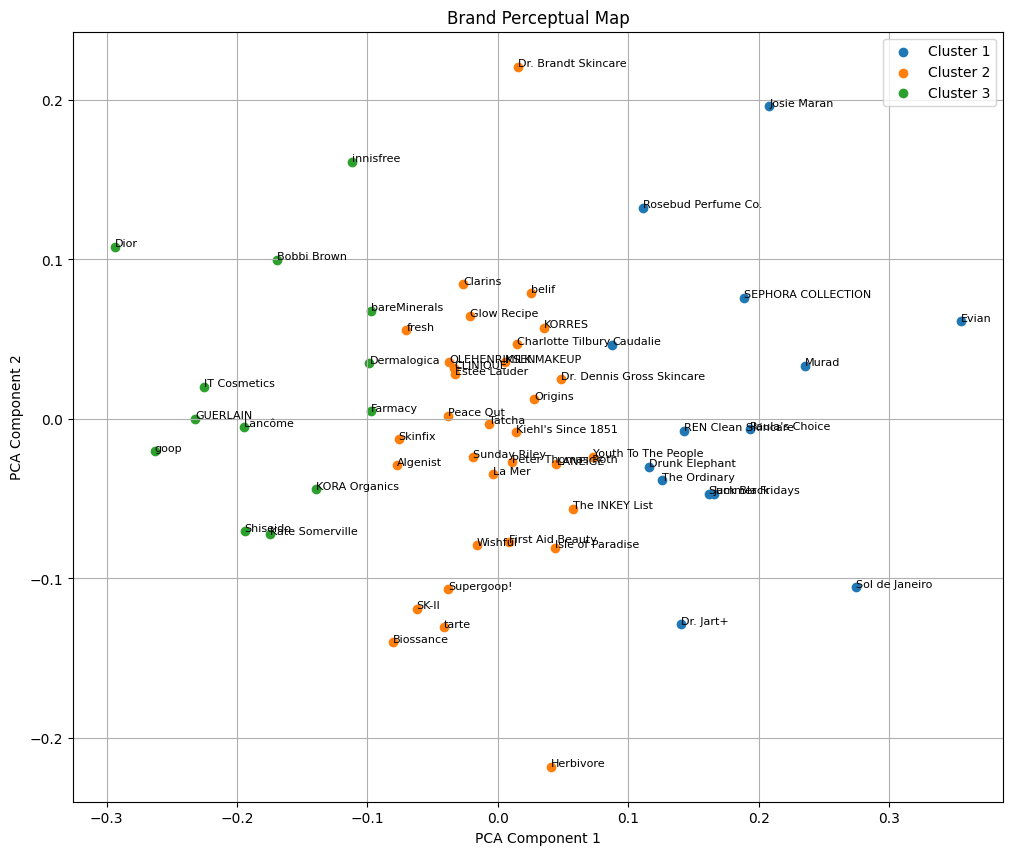

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Apply PCA for dimensionality reduction
pca = PCA(n_components=3)
pca_result = pca.fit_transform(brand_emotion_df)

# Choose the optimal number of clusters
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(pca_result)

# Create the perceptual map
plt.figure(figsize=(12, 10))
for cluster in range(n_clusters):
    plt.scatter(pca_result[clusters == cluster, 0],
                pca_result[clusters == cluster, 1],
                label=f'Cluster {cluster + 1}')

for i, brand in enumerate(brand_emotion_df.index):
    plt.annotate(brand, (pca_result[i, 0], pca_result[i, 1]), fontsize=8)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Brand Perceptual Map')
plt.legend()
plt.grid(True)
plt.show()


### RoBERTa Model

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


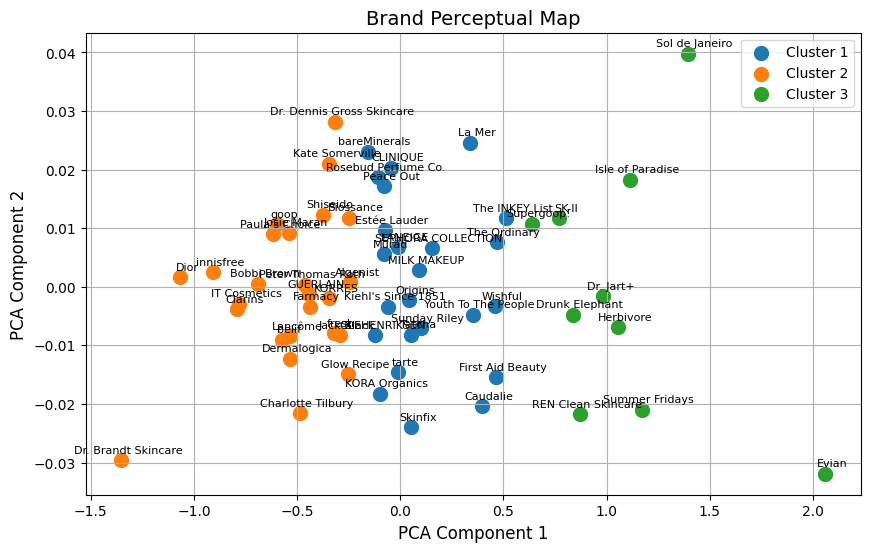

In [ ]:

pca = PCA(n_components=2)
pca_result = pca.fit_transform(reviews_pca_sum.tolist())

# Choose the optimal number of clusters
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(pca_result)

# Create the perceptual map with adjustments for clarity
plt.figure(figsize=(10, 6))
for cluster in range(n_clusters):
    plt.scatter(pca_result[clusters == cluster, 0],
                pca_result[clusters == cluster, 1],
                label=f'Cluster {cluster + 1}', s=100)

for i, brand in enumerate(reviews_pca_sum.index):
    plt.annotate(brand, (pca_result[i, 0], pca_result[i, 1]),
                 fontsize=8,
                 textcoords="offset points",
                 xytext=(5,5),
                 ha='center')

plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.title('Brand Perceptual Map', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()


# Results
Achieved an Accuracy score of 0.953 and an F1-score of 0.972

In [ ]:
# prompt: find the accuracy score of final_pred against label

from sklearn.metrics import accuracy_score

# Drop rows with NaN in either 'label' or 'final_pred' columns
test_cleaned = reviews.dropna(subset=['label', 'final_pred'])

accuracy = accuracy_score(reviews['label'], reviews['final_pred'])
print("Accuracy:", accuracy)


Accuracy: 0.9526468155500414


In [ ]:
# prompt: find precision,recall,gmean,auc for test_cleaned

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Assuming 'label' is the true label and 'final_pred' is the predicted label
precision = precision_score(test_cleaned['label'], test_cleaned['final_pred'])
recall = recall_score(test_cleaned['label'], test_cleaned['final_pred'])
f1 = f1_score(test_cleaned['label'], test_cleaned['final_pred'])
auc = roc_auc_score(test_cleaned['label'], test_cleaned['final_pred'])

gmean = np.sqrt(precision * recall)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("AUC:", auc)
print("G-mean:", gmean)


Precision: 0.9696450428396572
Recall: 0.9741760944417117
F1-score: 0.9719052876947614
AUC: 0.9065685667013753
G-mean: 0.9719079281641361


In [ ]:
thresh=[]
acc=[]
for threshold in range(0, 101, 1):  # Use integers for range
  threshold = threshold / 100.0
  reviews=pd.read_csv('output1.csv')
  reviews['CSbert'] = scaler.fit_transform(reviews[['CSbert']])
  result = reviews.apply(lambda x: delta(x['CSecr'], x['ES'], x['CSbert'], x['predBert'], x['emotions'],threshold),axis=1,result_type='expand') # Apply to each row (axis=1) and expand the result
  reviews[['final_pred', 'emotions']] = result
  test=reviews[reviews['final_pred']!='neutral']
  test['final_pred']=test['final_pred'].map({'positive':1,'negative':0})
  test.dropna(subset=['label', 'final_pred'],inplace=True)
  accuracy = accuracy_score(test['label'], test['final_pred'])
  print("Accuracy:", accuracy)
  thresh.append(threshold)
  acc.append(accuracy)

In [ ]:
reviews.head()

,text,label,rating,price_usd,product_name,brand_name,emotions,ES,CSecr,predBert,CSbert,pca,final_pred
0,yea this stuff didnt do crap tomy skin i am gl...,0.0,1.0,15.7,Hyaluronic Acid 2% + B5 Hydrating Serum,The Ordinary,[],-0.142857,0.142857,positive,0.091500,[0.3185879 0.2845435 0.3968686],negative
1,i have super sensitive skin and i have used th...,0.0,1.0,21.0,Mini Cicapair Tiger Grass Color Correcting Tre...,Dr. Jart+,[unpleasant],-0.200000,0.200000,negative,0.916660,[0.9371054 0.05498892 0.00790558],negative
2,not sure what happened but this face wash gave...,0.0,1.0,18.0,Mini Rice Wash Skin-Softening Cleanser,Tatcha,"[unpleasant, disappointment]",-0.575758,0.575758,negative,0.904758,[0.92931306 0.06324901 0.00743792],negative
3,very disappointed in the product i initially l...,0.0,1.0,65.0,Skinlongevity Long Life Herb Anti-Aging Face S...,bareMinerals,[unpleasant],0.000000,0.000000,negative,0.810866,[0.8678411 0.11088283 0.0212761 ],negative
4,i really wanted to love this product after see...,0.0,1.0,245.0,Facial Treatment Essence (Pitera Essence),SK-II,"[unpleasant, disappointment]",0.101852,0.101852,negative,0.159264,[0.44123408 0.2561103 0.3026557 ],negative


In [ ]:

# import matplotlib.pyplot as plt

# # Pair up positive and negative emotions
# emotion_pairs = [
#     ('gratitude', 'anger'),
#     ('satisfaction', 'unpleasant'),
#     ('relief', 'disappointment'),
#     ('joy', 'distress')
# ]

# # Create scatter plots for each pair
# for pos_emo, neg_emo in emotion_pairs:
#     plt.figure(figsize=(8, 6))  # Adjust figure size as needed
#     plt.scatter(brand_emotion_df[pos_emo], brand_emotion_df[neg_emo])

#     # Annotate each point with the brand name
#     for i, brand in enumerate(brand_emotion_df.index):
#         plt.annotate(brand, (brand_emotion_df.loc[brand, pos_emo], brand_emotion_df.loc[brand, neg_emo]), fontsize=8)

#     plt.xlabel(pos_emo.capitalize(), fontsize=12)
#     plt.ylabel(neg_emo.capitalize(), fontsize=12)
#     plt.title(f'{pos_emo.capitalize()} vs. {neg_emo.capitalize()} by Brand', fontsize=14)
#     plt.grid(True)
#     plt.show()
